# This is my jam Project
Charlotte Friis Theisen - Aymen Gannouni - Antoine Wehenkel

The data can be downloaded here: https://wetransfer.com/downloads/2b08e7ac50fe69f17554b9d37ffc45e820180122195654/89b41c7bffade4b6060d914178a1bf8a20180122195654/80d304
## Description 
Our project aims at analyzing a social music network called ”This is My Jam ”, which was active between 2011 and 2015. What motivates us the most is the opportunity we have to highlight the social interactions between people in the network, observe the spread of jams over time and analyze if people are connected by their music taste. 

A jam can be seen a facebook post or a tweet of a song, people can like the jams of the people they follow.

The initial research questions was all centered around the social netork and the spreading of jams. However, the final result of this project is different. The study of the spread of Jams quickly turned out to be irrelevant since the greatest number of Jams of a certain song was very small in comparison with the size of the social network. Although this happened sufficiently soon during the projet some signal analysis has been tried with these data. Primary analysis of Jams spread over networks is presented in the Appendix. 

Afterwards Spotify API has been used to collect more information about the songs shared, thanks to that, it was possible to define a new research question:

Is there some relation between people that can explain their taste in music?

Finally using the last research question it has been possible to analyze how the likes a person gives to jams define his music tastes based on graph analysis.

## Data Acquisition And Data Cleaning
In this part we first load and clean the 3 datasets provided by MyJam network. Then we complete these data with Spotify informations.

In [1]:
%matplotlib inline
#importing all relevant packages
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting
import pickle
import community
from scipy import sparse, stats, spatial
from SongJamAnalysis import *

plt.rcParams['figure.figsize'] = (10, 10)
plotting.BACKEND = 'matplotlib'

#Setting style for plotting
sns.set_style('whitegrid')
sns.set_palette('cubehelix',3)

First we need to load the data for the project. The data is stored in three tsv files:
- jams.tsc: All jams created including some matadata about the jam
- followers.tsv: Who follows who
- likes.tv: Who has liked which jams

To understand and work with this data we will load it into dataframes and do some data cleaning

In [2]:
data = pd.read_csv('jams.tsv', error_bad_lines=False, sep='\t', encoding='utf-8')

b'Skipping line 58038: expected 7 fields, saw 8\nSkipping line 58738: expected 7 fields, saw 8\n'
b'Skipping line 847113: expected 7 fields, saw 8\n'
b'Skipping line 1091137: expected 7 fields, saw 8\nSkipping line 1175359: expected 7 fields, saw 8\n'
b'Skipping line 1225919: expected 7 fields, saw 8\nSkipping line 1255341: expected 7 fields, saw 8\nSkipping line 1279655: expected 7 fields, saw 8\n'
b'Skipping line 1330659: expected 7 fields, saw 8\n'
b'Skipping line 1448017: expected 7 fields, saw 8\nSkipping line 1543877: expected 7 fields, saw 8\n'
b'Skipping line 1579553: expected 7 fields, saw 8\nSkipping line 1612432: expected 7 fields, saw 8\n'
b'Skipping line 1784572: expected 7 fields, saw 8\n'


Importing the data was only possible if we allowed for bad lines to be skipped, however we see that it is less that 20 and are not very concerned with these lines as we assume it will not make a difference in the later analysis. 

By manually inspecting the raw data it is not difficult to find lines that are being read in a wrong way. In parts of the data there are newlines and \t separators that are not placed correctly. This results in empty lines and lines where the data has been shifted to either side and split between several lines. In order to figure out how many lines are concerned with these kinds of errors we sort the dataframe on the date and thus all the lines where the format of the field creation_date is not in a date format will appear at the end. We decided to simply remove all these lines so that the ones left are the ones read correctly. It should be noted that most of the information could have been recovered by manually inspecting and removing places with faulty new lines and tabs. However, we decided that it would be too time consuming for the project. It is observed that at maximum a few hundred jams have been removed (that potentially could have been restored) and in comparison with the more than 2.000.000 jams that are part of the analysis, this is very unlikely to have any real influence on the later analysis.

Furthermore, it is observed that some song titles and artists are NaN's. This might be due to some fault in the data collection, but could also simply be because it has been possible to create jams without specifying the artist or title and therefore we leave these jams in the dataset.

We see that all jam id's are unique and that all lines contain a user id and a creaton date.

In [3]:
data = data.sort_values(by='creation_date')[0:2090068-605]

description = data.describe()
description[0:2]

jam_id  user_id   artist    title creation_date     link spotify_uri
count   2089463  2089463  2088219  2089076       2089463  2072124     1479762
unique  2089463   132297   240051   568426          1492   950443      401193

In [4]:
data.head()

jam_id                           user_id  \
0  c2e76bb92c7fa733fdfc9be40bb0e4ea  b99ebf68a8d93f024e56c65e2f949b57   
1  5d2bc46196d7903a5580f0dbedc09610  c1066039fa61eede113878259c1222d1   
2  4849f8c893a792032dbc15eb77cfd0cd  d8a96caeef5c7d8dbdc9cec28aa9c044   
3  8940ff2e8e38c8f1a4676e09d152c0cd  b1c81a51f5286d70e5820ecb85aeba96   
4  4020b45a4c6d5515a3b62c489e169828  4fdc0257bc476bffd3e73564ecaa75e0   

               artist                   title creation_date link  \
0        Orange Juice               Rip It Up    2011-08-26  NaN   
1         Erkin Koray                Hele Yar    2011-08-26  NaN   
2              Stereo  Somewhere In the Night    2011-08-26  NaN   
3  The Mills Brothers  I Got Her Off My Hands    2011-08-26  NaN   
4             Various           Zum Volksfest    2011-08-26  NaN   

                            spotify_uri  
0  spotify:track:6AGhDIyDbRonzGTdbIsNXa  
1                                   NaN  
2  spotify:track:2ZM9sVP0blBj1lNIEg4dgn  
3  spotify:track:096elxAmYuyAFJKPLrS5oY  
4                                   NaN

The social connections (network) is described by the following dataframe where all followers are linked to the users they follow. In this dataframe we observe no values that seem faulty.

In [5]:
net = pd.read_csv('followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
net.head(5)

followed_user_id                  follower_user_id
0  b99ebf68a8d93f024e56c65e2f949b57  1ebda3c5e05265626ab18401fb33a90a
1  c1066039fa61eede113878259c1222d1  1ebda3c5e05265626ab18401fb33a90a
2  d8a96caeef5c7d8dbdc9cec28aa9c044  1ebda3c5e05265626ab18401fb33a90a
3  2969c319775d884b860a897ba9d6156f  1ebda3c5e05265626ab18401fb33a90a
4  ff58e67948917e0ff71ba4b33e158365  1ebda3c5e05265626ab18401fb33a90a

The last dataframe contains all the likes and thus each user is linked to the jam they liked. This dataframe also seem to contain no faulty values.

In [6]:
likes = pd.read_csv('likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
likes.head()

user_id                            jam_id
0  c1066039fa61eede113878259c1222d1  5d2bc46196d7903a5580f0dbedc09610
1  b99ebf68a8d93f024e56c65e2f949b57  8940ff2e8e38c8f1a4676e09d152c0cd
2  c1066039fa61eede113878259c1222d1  4849f8c893a792032dbc15eb77cfd0cd
3  c1066039fa61eede113878259c1222d1  4020b45a4c6d5515a3b62c489e169828
4  b99ebf68a8d93f024e56c65e2f949b57  4849f8c893a792032dbc15eb77cfd0cd

Spotify API scraping and creation of one df which contains everything needed for the data exploration about jams.

Data quality plays a major role in avoiding misleading results later in the data analysis. Therefore the spotify web API was used to enrich the initial data after removing the jams that was not identified in the API.  
The following endpoints were used to gather additional information on the jammed tracks:  

* <https://api.spotify.com/v1/tracks>: This endpoint was firstly used to extract the other identifiers of a certain track such as ``album_id`` and ``arstist_id`` 
* <https://api.spotify.com/v1/albums>: This endpoint was used to extract the release year of an album in order to know the year in which a certain track was released.
* <https://api.spotify.com/v1/artists>: Since there was no information on the genres of the tracks, this endpoint was used to get the genres of songs played by a certain artist.  
* <https://api.spotify.com/v1/audio-features>: This endpoint was used to get the audio features of a track. 

Because od the API rate limit, these endpoints were used to query many track ids at the same time to reduce the number of requests that should be sent. Another limitation of the API was that the provided access token was only valid for one hour. With all these limitations, we were able to query over 100 thousand items per hour. Totally, we gathered information of 401193 tracks, 198256 albums, and 68620 artists.  

Some samples of the collected API data are presented in the following


In [7]:
artists = pd.read_pickle('artists_ntds.pkl')
artists.head()

artist_id                                      artist_genres
0  2u7xZP39dtED9EuRX9MUwu  [alternative rock, art rock, c86, chamber pop,...
1  6Q3K0BS90FmHGdbLsl3GJd             [dutch pop, vintage french electronic]
2  5v8bwWRbu7AI3YFhzoM6Ha  [adult standards, big band, cabaret, christmas...
3  4mO4aGO6u29UyR6XLZR9XW  [alternative pop, alternative rock, anti-folk,...
4  3UpIbyXfGzmHG6TMH4dJEk  [alternative pop, anti-folk, folk, folk christ...

In [8]:
albums = pd.read_pickle('albums_ntds.pkl')
albums.head()

album_uri  album_year
0  0M8nGzVxKuM41Wr73dU9ex      1982.0
1  1Xs57QqOuXl4kckTeL4rgD      2008.0
2  5JovwgVTHzOz6bFfXDHmtO      2008.0
3  1OupCV5WetcsUe8GcJ8F1U      2005.0
4  55HdXJwG0d9iMaXgPrGmOg      2005.0

In [9]:
features = pd.read_pickle('features_ntds.pkl')
features.head()

spotify_uri  acousticness  danceability  \
0  spotify:track:6AGhDIyDbRonzGTdbIsNXa        0.0532         0.881   
1  spotify:track:2ZM9sVP0blBj1lNIEg4dgn        0.0268         0.655   
2  spotify:track:096elxAmYuyAFJKPLrS5oY        0.8560         0.787   
3  spotify:track:6W9rl3K4onX5oe2VU1HX7J        0.0121         0.636   
4  spotify:track:7l2KfEDMVmRVj3lAvifiEd        0.2400         0.347   

   duration_ms  energy  liveness  loudness  speechiness    tempo  valence  
0     320413.0   0.546    0.0497    -9.357       0.0407  102.814    0.852  
1     303413.0   0.688    0.0816    -7.464       0.0308  118.166    0.691  
2     144960.0   0.217    0.0574   -10.530       0.0379  108.465    0.579  
3     185973.0   0.907    0.0670    -4.083       0.0319  134.932    0.887  
4     263933.0   0.606    0.1300    -7.741       0.0285  138.869    0.279

To show an example of the data collection using the Spotify API the following code has been included.

In [10]:
def spotify_api_call(dataframe,start,end,endpoint):
    responses = []
    for i in tqdm(np.arange(start,end,10)):
        a = [val+',' for val in dataframe[endpoint[:-1]+'_uri'][i:i+10].values]
        res = requests.get('https://api.spotify.com/v1/'+endpoint+'?ids='+''.join(a)[:-1], headers=spotify_api_set_connection())
        if res.status_code != 200:
            print(res.text)
            time.sleep(res.json()['Retry-After'])
        else:
            for j in res.json()[endpoint]:
                responses.append(j)
    return responses

In [11]:
def spotify_api_set_connection():
    client_id ='secret'
    secret_id ='secret'
    grant_type = 'client_credentials'
    query = requests.post("https://accounts.spotify.com/api/token", data={'grant_type': grant_type}, auth = (client_id,secret_id))
    token = query.json()['access_token']
    headers = {"Authorization": "Bearer {}".format(token)}
    return headers

## Data Exploration

In this section we will gothrough some of the main properties of the raw data and create simple weighted and unweighted social networks based on the followers.

### Jams' features main properties study
To study the features of the music that was jammed in the dataset, we first take a look at the genres.

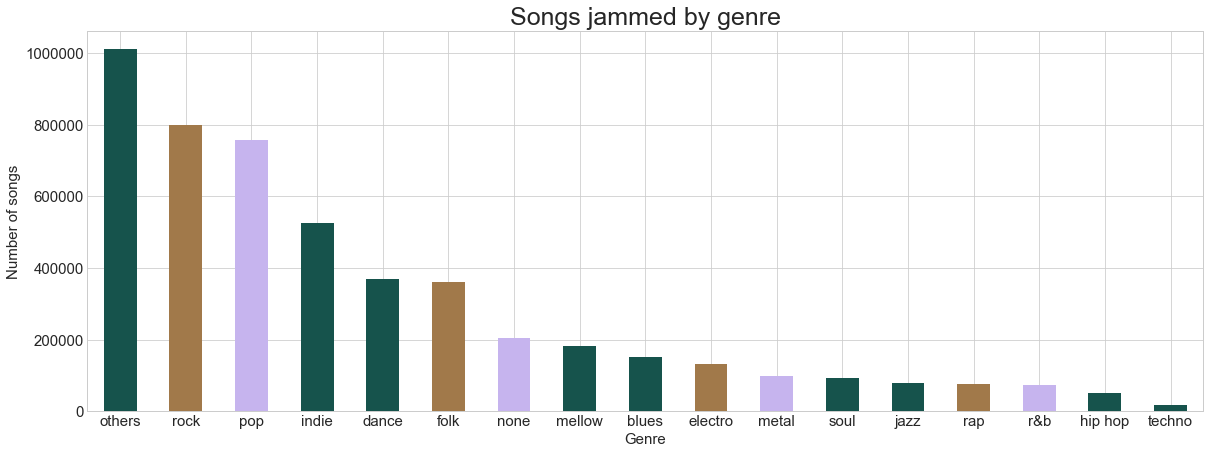

In [12]:
genres_for_net = pickle.load(open('data_genre_not_grouped',"rb"))
data_songs_genres = genres_for_net[genres_for_net.columns[-17:]].sum()
#plotting the amiunt of jams withinn weach genre
plt.figure(figsize=(20,7))

data_songs_genres.sort_values(ascending=False).plot.bar()

plt.xticks(rotation='horizontal',size=15)
plt.yticks(size=15)
plt.title('Songs jammed by genre',size=25)
plt.xlabel('Genre',size=15)
plt.ylabel('Number of songs',size=15)
plt.show()

It should be noted that the genre of each jam is based on the genre of the artist who made the song. This means that often songs will have more than one genre. Furthermore the Spotify API originally returned more than 1.500 different genres and we therefore grouped them within major genres. However, a large part of the genres did not belong to any of our major genres and we therefore created the 'other' category. Also a large part of the artist were not associated with any genre by the Spotify API and therefore a category called 'none' exists. Apart from that the most noticable thing is that the major genres consist of Pop, Rock, Indie, Dance and Folk.


The next thing we're interested in examining is the activity in the network over time and therefore we visualized the amount of jams per day along with a moving average.

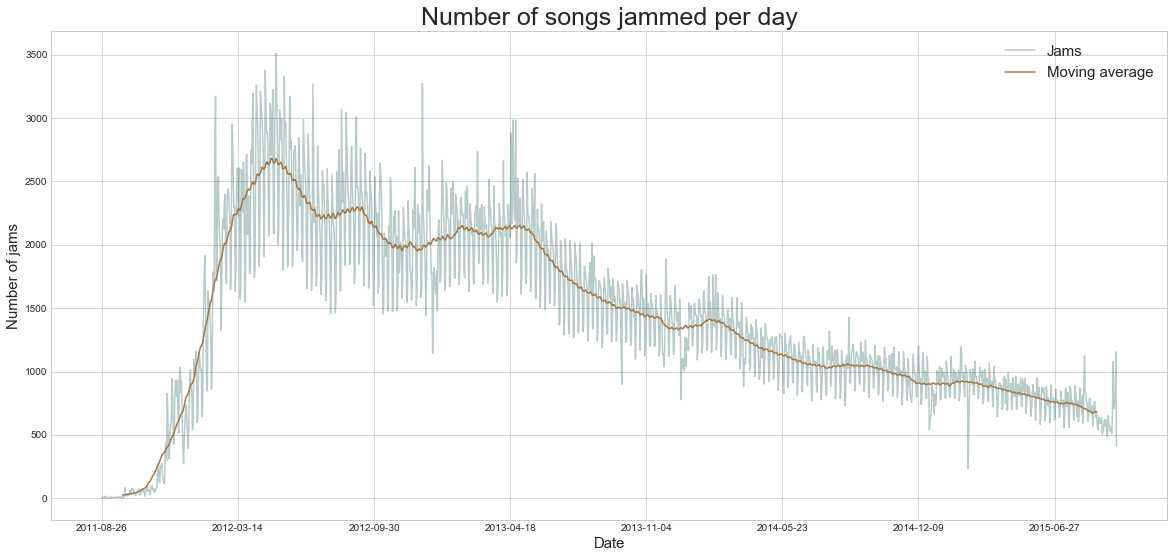

In [13]:
#plotting jams per day with moving average
data_time = data.groupby('creation_date').count()
avg = data_time['jam_id'].rolling(60,center=True).mean()

data_time.plot(x=data_time.index.values,y='jam_id',kind='line',figsize=(20,9),alpha=0.3, label='Jams')
plt.plot(avg.values,label='Moving average')
plt.title('Number of songs jammed per day',size=25)
plt.xlabel('Date',size=15)
plt.ylabel('Number of jams',size=15)
plt.legend(fontsize=15);

Here we see that after the start in the end of 2011 the network had it's prime time during 2012. Half way through 2013 the activity slowly starts decreasing and in 2015 when the social network was closed there weren't musch more than 500 jams per day.

### Graph properties analysis of the natural social networks (Unweighted and weighted)

#### Unweighted social network

To explore the dataset in a graph context we first create a simple unweighted network. This network represents the social links between people.

To create this network we look at the net dataframe and add all the unique user id's as nodes to the network. Next we add edges between all the relevant nodes by going through the net dataframe.

In [14]:
# Network creation
if False:
    followed = list(net['followed_user_id'].unique())
    followers = list(net['follower_user_id'].unique())

    nodes = list(set(followed+followers))

    # Creating the network with nodes
    G = nx.Graph()
    G.add_nodes_from(nodes)

    # Adding all edges
    for i in tqdm(range(len(net))):
        if net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]:
            G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

    # Save the graph
    nx.write_gpickle(G,'G')

In [15]:
# Load the graph
G = nx.read_gpickle('G')
len(G.nodes)

101273

The first thing we need to examine is the components of the network. Since we need to work with a connected graph for the signal processing, we want to chose the largest connected component to continue working with.



In [16]:
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
print('The number of components in the network is: {}'.format(len(Gcc)))
print('The size of the largest component in the network is: {}'.format(len(Gcc[0].nodes)))

The number of components in the network is: 354
The size of the largest component in the network is: 100518


354 seems like many components and it is therefore important to examine the size of these before discarding all but the largest.

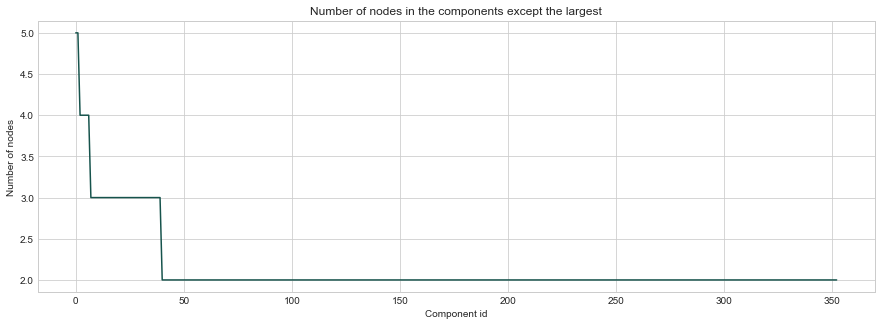

In [17]:
# Number of nodes in all components except the largest
nb_comp = []
for i in range(1,len(Gcc)):
    nb_comp.append(len(Gcc[i].nodes))
#plotting the size of components
plt.figure(figsize=(15,5))
plt.plot(nb_comp);
plt.title('Number of nodes in the components except the largest');
plt.xlabel('Component id');
plt.ylabel('Number of nodes');

Since most components only contain two nodes and the largest contain 5. It's reasonable to continue with just the largest component. As seen eralier the largest contain 101.273 nodes.

The unweigted network G has 100518 nodes.
The unweigted network G has 1294160 edges.
The nodes in G has an average degree of 25.75.


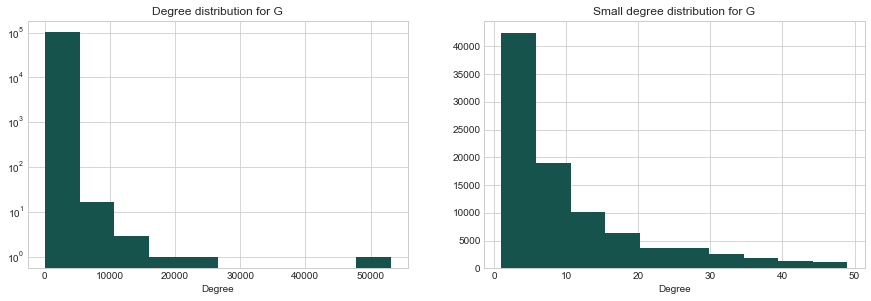

In [18]:
#keeping only the largest component
G = Gcc[0]

print('The unweigted network G has {} nodes.'.format(len(G.nodes())))
print('The unweigted network G has {} edges.'.format(G.size()))
print('The nodes in G has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G)).values()))/len(G.nodes())))

fig = plt.figure(1,figsize=(15,10))

#plotting degree distribution
degrees = np.array(list(dict(nx.degree(G)).values()))
plt.subplot(221)
plt.hist(degrees, log=True);
plt.title('Degree distribution for G');
plt.xlabel('Degree');

#plotting distribution for small degrees
small_degrees = degrees[degrees < 50]
plt.subplot(222)
plt.hist(small_degrees);
plt.title('Small degree distribution for G');
plt.xlabel('Degree');

We see that almost all nodes have a very small degree and most of the below 10. However one very well connected node exists in the network with around 50.000 connections.


Now we will try to detect communities in the network. If communities are found, we will then try to analyze if people within a community share same music taste. To detect communities we use networkx which implements the Louvain method to detect them.

In [19]:
genres = pickle.load(open('data_genre', 'rb'))

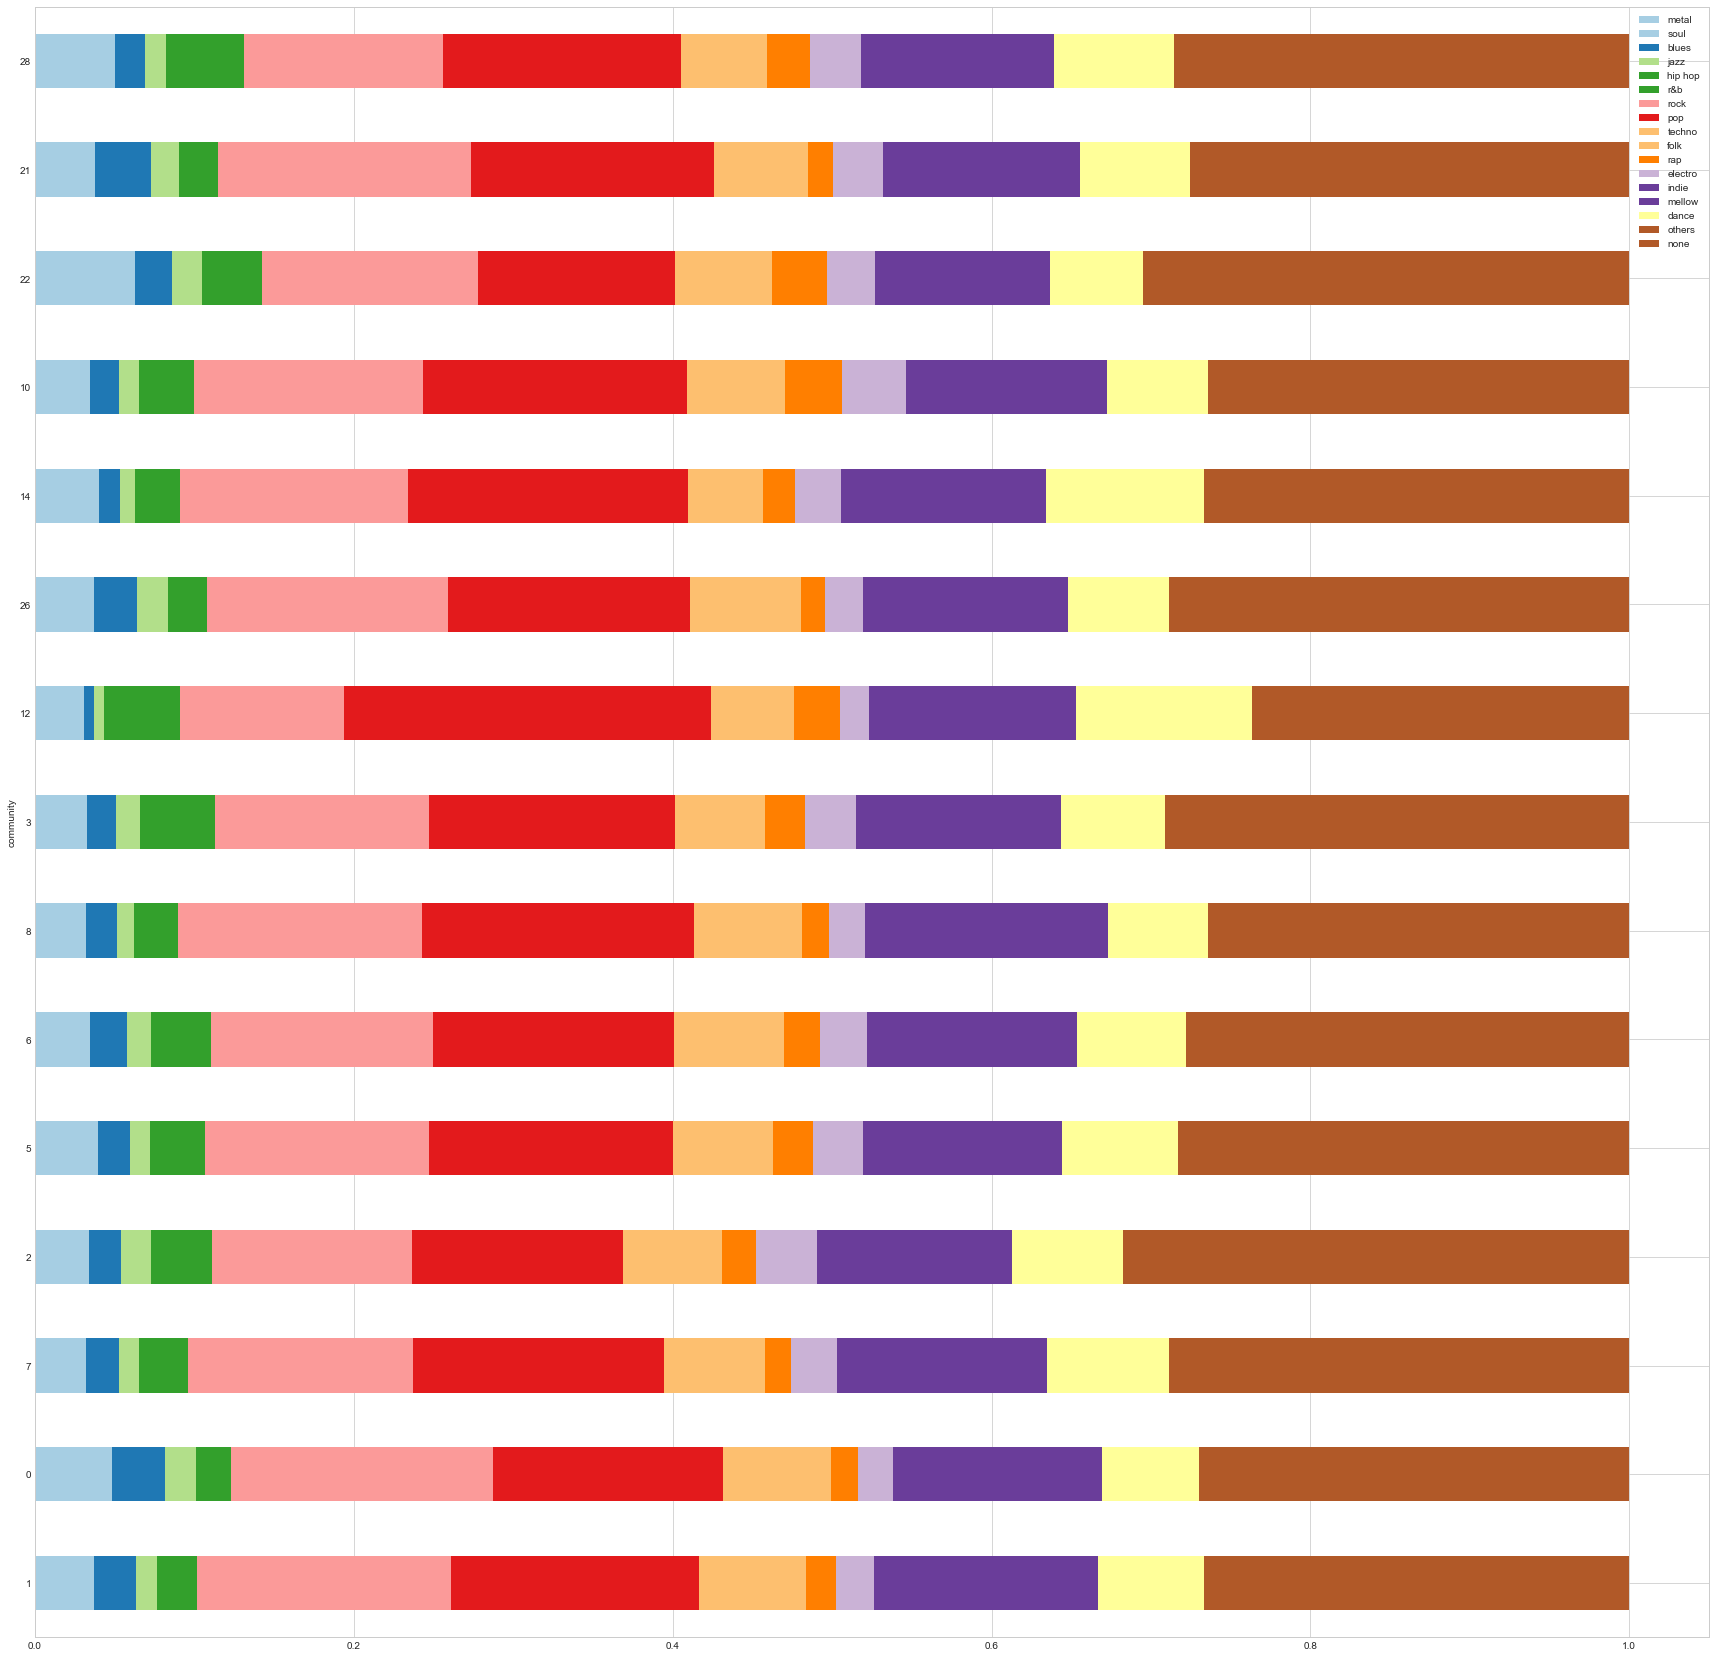

In [20]:
#comms = community.best_partition(G)
#pickle.dump(comms, open('comms', 'wb'))
comms = pickle.load(open('comms', 'rb'))
compareCommunitiesTaste(comms, genres)

In the plot above we present the repartition of the music jammed by user of the 15 largest communities. It can be observed that the communities are very similar in term of music taste. It means that the social network does not represent the taste of the users very well. It also implies that people tend to follow others for different reasons than just the fact they share similar taste.

#### Weighted social network
In the later analysis when we would like to observe how Jams propagate through a network. It could be important to consider how well connected two given nodes are and not just that they are simply connected. If two users interact many times we assume that they are also more likely to be influenced by each other. Therefore we will create a weighted graph where the edges' weights depend on the amount of times two users have liked each others jams.

In [21]:
# Merging likes and data
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')
grouped = merge.groupby(['user_id_x','user_id_y']).count()
grouped.sort_values(by='jam_id',ascending=False).head()

jam_id
user_id_x                        user_id_y                               
8e01cba1a99a9eae7ffbb7bb76aac150 fd3292545fd8b2c8dcbdb86335052238    1723
a12e5a826d390a0a138c21841b8f34c7 fd3292545fd8b2c8dcbdb86335052238    1619
8eaf92d9023c44e657193e50f09e7725 fd3292545fd8b2c8dcbdb86335052238    1404
126932e6915c39fd6127c0c635461307 126932e6915c39fd6127c0c635461307    1307
dc87e7ab06a5aad596130c6966d2fe0c fd3292545fd8b2c8dcbdb86335052238    1163

Since the merge dataframe here is sorted by the number of likes form user_x to user_y, we can see that the maximum number of likes are around a 1000, however most of them are far lower.

In [22]:
#creating the weigthed network and adding the weights
if False:
    G_w = G
    for i in tqdm(range(len(merge))):
        if grouped.iloc[i].name[0] in G_w.nodes and grouped.iloc[i].name[1] in G_w.neighbors(grouped.iloc[i].name[0]):
                G_w[grouped.iloc[i].name[0]][grouped.iloc[i].name[1]]['weight'] += grouped.iloc[i]['jam_id']
    nx.write_gpickle(G_w,'G_w')

In [23]:
# Load the graph
G_w = nx.read_gpickle('G_w')

The weigted network G_w has 100518 nodes.
The weigted network G_w has 1294160 edges.
The nodes in G_w has an average degree of 123.00.


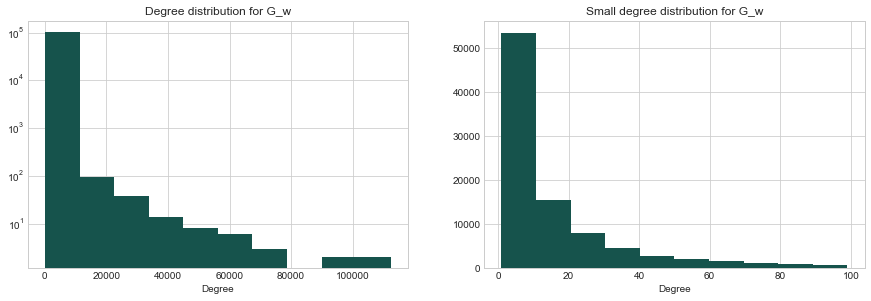

In [24]:
#basic properties of the weighted network
print('The weigted network G_w has {} nodes.'.format(len(G_w.nodes())))
print('The weigted network G_w has {} edges.'.format(G_w.size()))
print('The nodes in G_w has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_w,weight='weight')).values()))/len(G_w.nodes())))


fig = plt.figure(1,figsize=(15,10))

#pltotting degree distribution
degrees_w = np.array(list(dict(nx.degree(G_w,weight='weight')).values()))
plt.subplot(221)
plt.hist(degrees_w, log=True);
plt.title('Degree distribution for G_w');
plt.xlabel('Degree');

#plotting the small degrees
small_degrees_w = degrees_w[degrees_w < 100]
plt.subplot(222)
plt.hist(small_degrees_w);
plt.title('Small degree distribution for G_w');
plt.xlabel('Degree');

Again we see that even though the average degree is much higher than for the unweighted network most of the nodes still have very small degrees below 20. A few degrees have extremely high degrees around 100.000.

Again we take a look at the communities in the weighted network and observe the taste of the main communities.

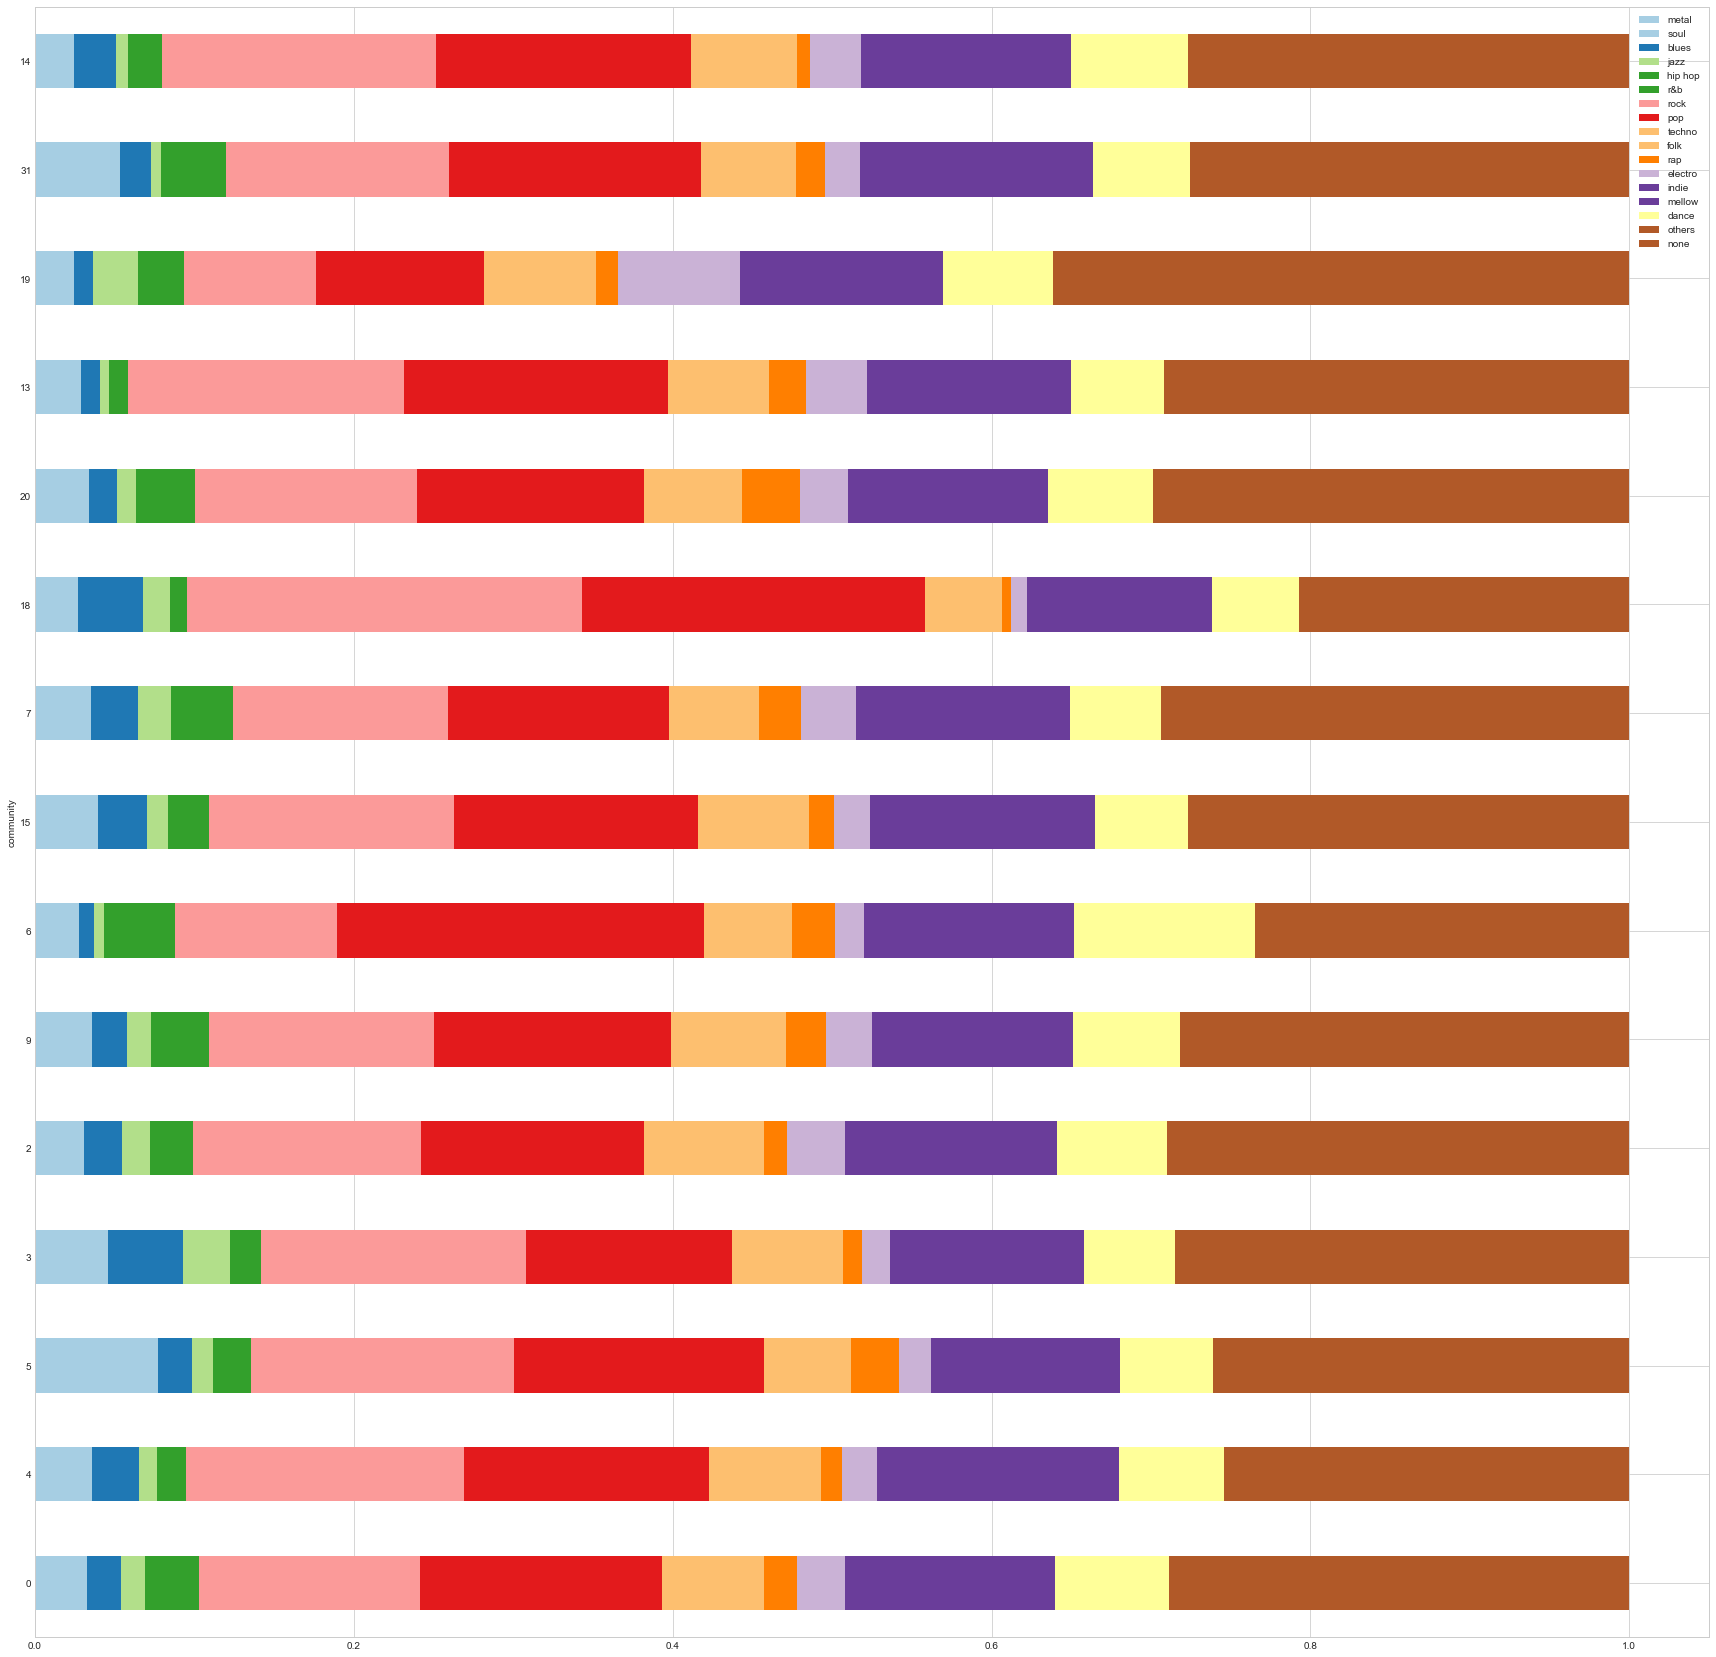

In [25]:
#comms = community.best_partition(G_w)
#pickle.dump(comms, open('comms2', 'wb'))
comms = pickle.load(open('comms2', 'rb'))
compareCommunitiesTaste(comms, genres)

In the weighted network we observe that the community seem to have more different music taste. It lead us to interpret as a fact that the likes of a person defines the type of music he could jam more sufficiently than simple the person he follows.

## Data Exploitation
Thanks to the data exploration we have been able to understand a lot about the My Jam social network. First, it has been shown that working with the simple social graph would probably not lead to interesting conclusion. Indeed it seems that this network does not well represent any music taste. Then, using a weighted social network we have been able to show that music taste is probably more influenced by the likes you give to jams than just to the people you follow. 

It is why in the data exploitation we are interested in examining further these primary conclusions. In order to be able to easily use signal processing over the graph first we build a pruned social network. First we use this graph to analyze if there is some spread of taste in the graph. afterwards we construct an artificial graph which well reresent the music taste of people. This graph is also used to look for any propagation of Jams over time in the network and this analysis can be found in the Appendix.

In [26]:
#removing nodes with degree below 60
G_w_nodes = list(G_w.nodes())
G_w_degrees = G_w.degree(G_w_nodes,weight='weight')

for i in G_w_nodes:
    if G_w.degree[i] < 60:
        G_w.remove_node(i)
if not(nx.is_connected(G_w)):
    #keeping the largest connected component
    Gcc_w = sorted(nx.connected_component_subgraphs(G_w), key = len, reverse=True)
    Gcc_w = Gcc_w[0]
else:
    Gcc_w = G_w

print('The weigted network Gcc pruned has {} nodes.'.format(len(Gcc_w.nodes())))
print('The weigted network Gcc pruned has {} edges.'.format(Gcc_w.size()))
print('The nodes in Gcc pruned has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(Gcc_w,weight='weight')).values()))/len(Gcc_w.nodes())))

The weigted network Gcc pruned has 5288 nodes.
The weigted network Gcc pruned has 384862 edges.
The nodes in Gcc pruned has an average degree of 1611.57.


Using this network we observe the different propagation of music taste over the network. The music taste for each person in the graph is defined by the proportion of genre music the person has jammed. But first we look again for the community music tastes.

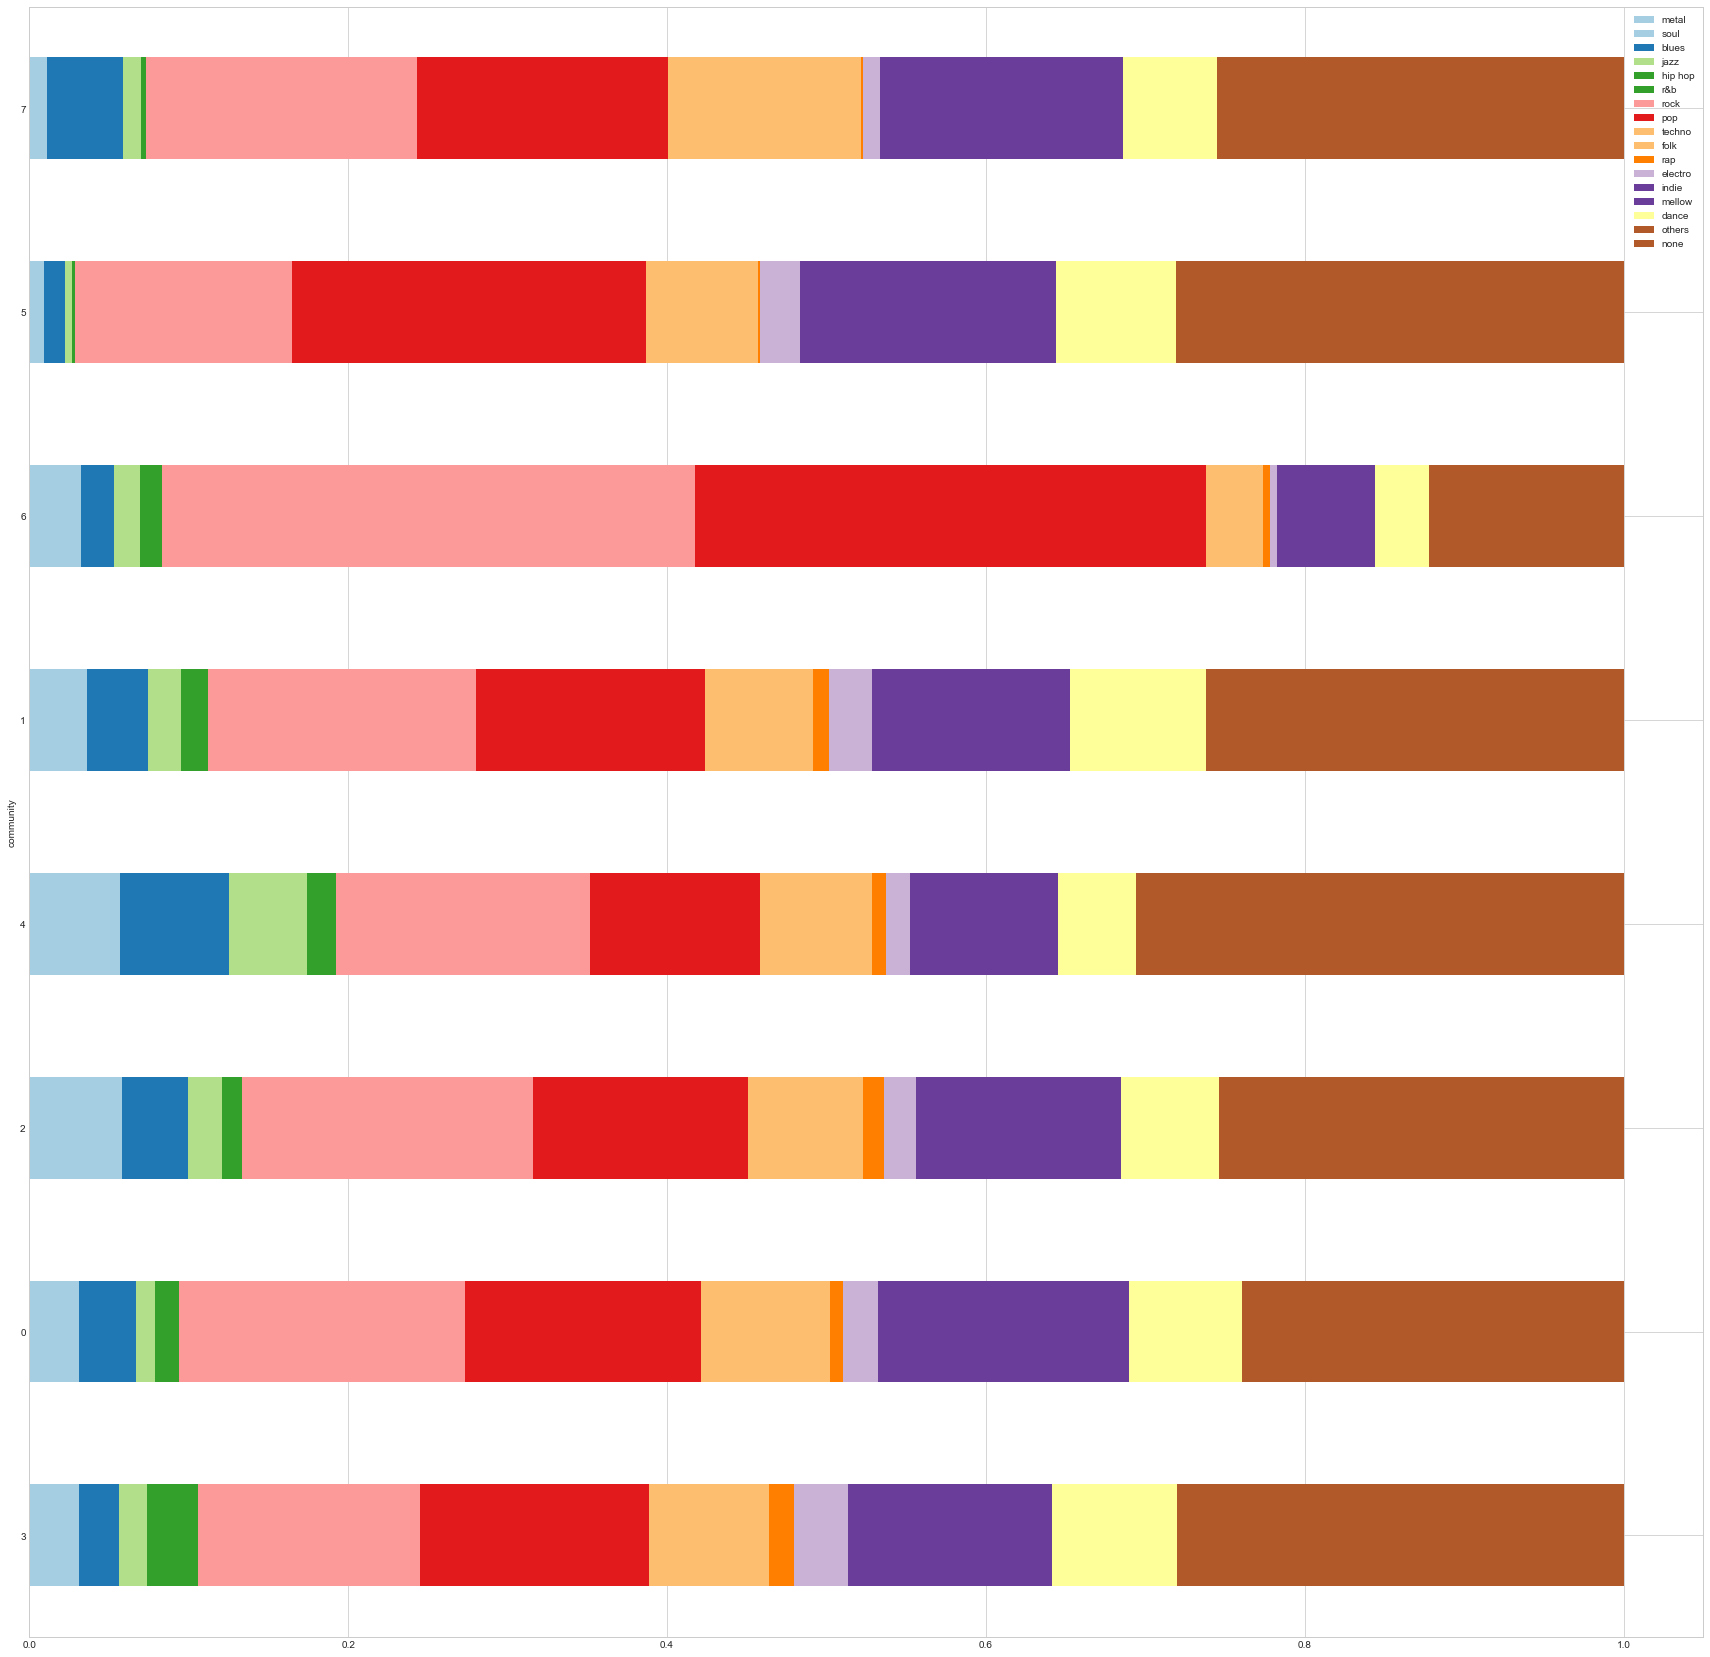

In [27]:
#comms = community.best_partition(Gcc_w)
#pickle.dump(comms, open('comms3', 'wb'))
comms = pickle.load(open('comms3', 'rb'))
compareCommunitiesTaste(comms, genres)

Communities seem to have very similar average taste, which is probably a sign that even the pruned network does not really represent the music taste. We want to confirm that by looking at signal processing over graph. We define the signals to be the proportion of each genre each person has jammed.

2018-01-22 20:49:20,079:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (5241 x 5241) may take some time.


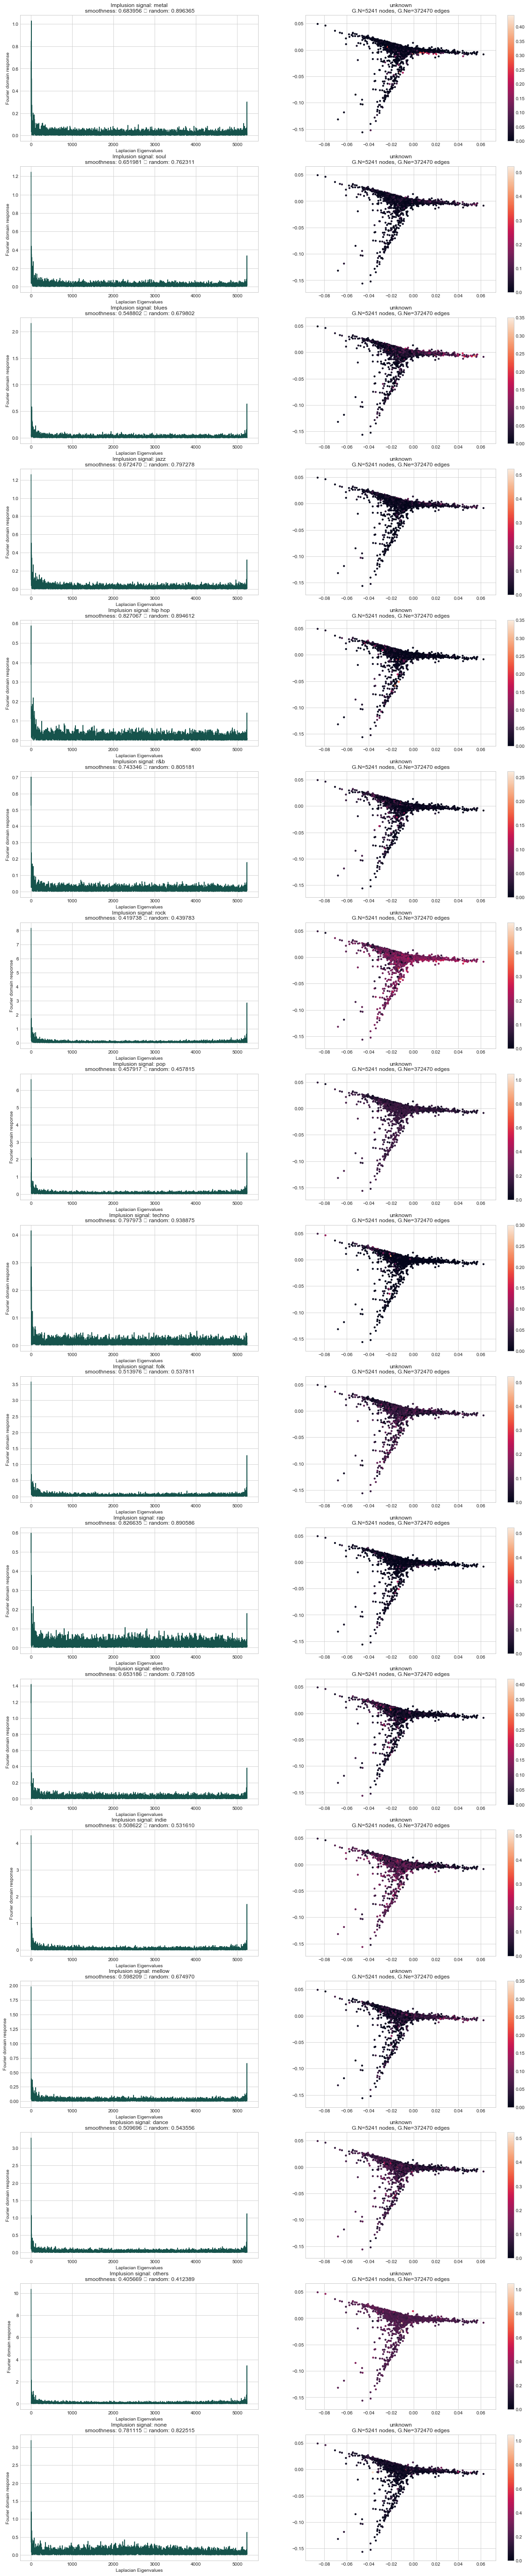

In [28]:
#removing nodes for which we do not have information about genres
Gcc_w.remove_nodes_from(list(set(Gcc_w.nodes) - set(genres.index.values)))

#create graph
G_f = graphs.Graph(nx.adjacency_matrix(Gcc_w))

#compute fourier
G_f.compute_laplacian('normalized')
G_f.compute_fourier_basis()

signals = genres.loc[list(Gcc_w.nodes())].values

#plot the signals
fig, axes = plt.subplots(signals.shape[1], 2, figsize=(20, 100))

for i in range(signals.shape[1]):
    signal = signals[:, i]
    G_f.set_coordinates(G_f.U[:,1:3])
    G_f.plot_signal(signal,vertex_size=10, ax=axes[i, 1])
    #plt.axis([-1,1,-1,1])

    axes[i, 0].plot(np.abs(G_f.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_f.L @ signal / np.linalg.norm(signal)**2
    
    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    shuffled_signal = signal.copy()
    for j in range(5):
        np.random.shuffle(shuffled_signal)
        smoothness_rand += shuffled_signal.T @ G_f.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)
    
    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (genres.columns[i], smoothness,smoothness_rand))


As we can see none of the signal seems very smooth along the graph. Although the signal gradient is better then the signal applied at random we can conclude that the pruned weighted social network does not represent music taste very well. 

Now that we have observed that purely social network does not well represent the taste of the people we would like to create an artificial network which represent well the taste of people. The idea is to use the likes of people to infer the genre of music they will probably Jam. A priori we cannot be sure that the person's likes really define his taste, indeed a person could like a Jam just because he likes the person who jammed it. And as we observed the social links does not well represent music taste. However it might also be that people like music within their favorite genres and also jam music within these genres. 

To construct the genre of "likes" network and analyze its accuracy to represent the genre of what is being jammed we select only the most active users. These users will be linked in the network depending on the similarity of the genre of the music they liked.

In [29]:
# Merging likes and information about the jams.
data_likes = data.dropna(subset=['spotify_uri'])
data_likes = data_likes.groupby('user_id').count()
likes_grouped = likes.groupby('user_id').count()
data_likes = data_likes.merge(likes_grouped, left_index=True, right_index=True)

# Compute activity of each member.
data_likes = data_likes[['jam_id_x', 'jam_id_y']]
data_likes = data_likes[(data_likes['jam_id_x'] != 0) & (data_likes['jam_id_y'] != 0)]
data_likes['activity'] = data_likes['jam_id_x'] + data_likes['jam_id_y']

users = data_likes.sort_values('activity', ascending=False).iloc[:2000].index.values

likes_users = likes[likes.user_id.isin(list(users))]

In [30]:
genres_for_net = pickle.load(open('data_genre_not_grouped',"rb"))
likes_users = likes_users.merge(genres_for_net, on='jam_id')
likes_users.drop(columns=likes_users.columns[1:10], inplace=True)
likes_grouped = likes_users.groupby('user_id_x').sum()
likes_grouped = likes_grouped.divide(np.sum(likes_grouped.values, axis=1), axis=0)

We then need to compute the distance between the taste of each user. At first we connect every user to one another and give them a weight related to their distance, but only the 50 strongest connections for each nodes is used in the final network.

In [31]:
#computing the similarity/distance between all nodes
distances = spatial.distance.squareform(spatial.distance.pdist(X=likes_grouped.values, metric='cosine'))
kernel_width = distances.mean() * 10
weights = np.exp(-np.square(distances/kernel_width**2)) - np.eye(len(distances))

In [32]:
#Discarding all connections but the 50 strongest
NEIGHBORS = 50
# Find sorted indices for each row
sorted_row_idx = np.argsort(weights, axis=1)
for row in range(len(sorted_row_idx)):
    weights[row, sorted_row_idx[row, :-NEIGHBORS]] = 0

#if there are selfloops they will be removed
if sum(sum(abs(weights-weights.transpose()))) != 0:
    # Make W is symmetric
    bigger = weights.transpose() > weights
    weights = weights - weights*bigger + weights.transpose()*bigger
    #weights = (weights + weights.transpose())/2

Now that the weighted adjacency matrix is created a graph object will be made and we will analyze the network in a signal processing context.

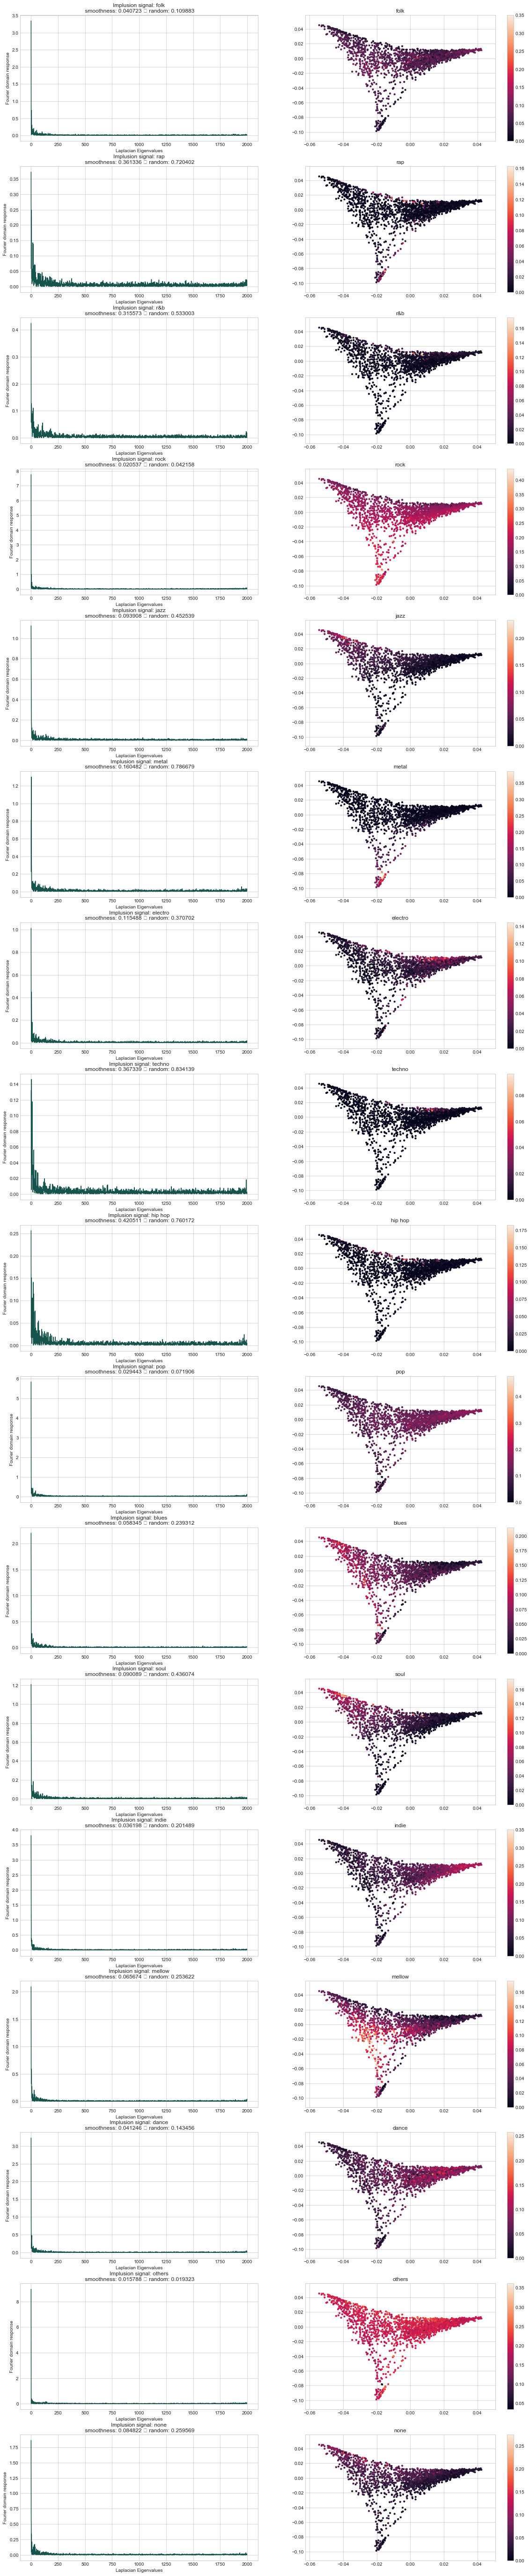

In [33]:
#create graph
G_likes = graphs.Graph(weights)
#compute fourier
G_likes.compute_laplacian('normalized')
G_likes.compute_fourier_basis()
#plot the signal
fig, axes = plt.subplots(len(likes_grouped.columns), 2, figsize=(20, 100))
i = 0
for column in likes_grouped.columns:
    signal = likes_grouped[column].values

    G_likes.set_coordinates(G_likes.U[:, [1, 2]])
    G_likes.plot_signal(signal,vertex_size=10, ax=axes[i, 1])

    axes[i, 0].plot(np.abs(G_likes.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    axes[i, 1].set_title(column)
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_likes.L @ signal / np.linalg.norm(signal)**2

    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    for j in range(5):
        shuffled_signal = likes_grouped.sample(frac=1)[column].values
        smoothness_rand += shuffled_signal.T @ G_likes.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)

    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (column, smoothness,smoothness_rand))
    i += 1

Without surprise the signals are very smooth on this graph, indeed this graph has been built by the likes genre proximity between people and it is thus logical to obtain that these signals are smooth in it.

The next thing we will examine is whether the genre of the music jammed by the users can be explained by this network. If this is the case it shows a connection between the genre of music you like and the genre of music you jam.

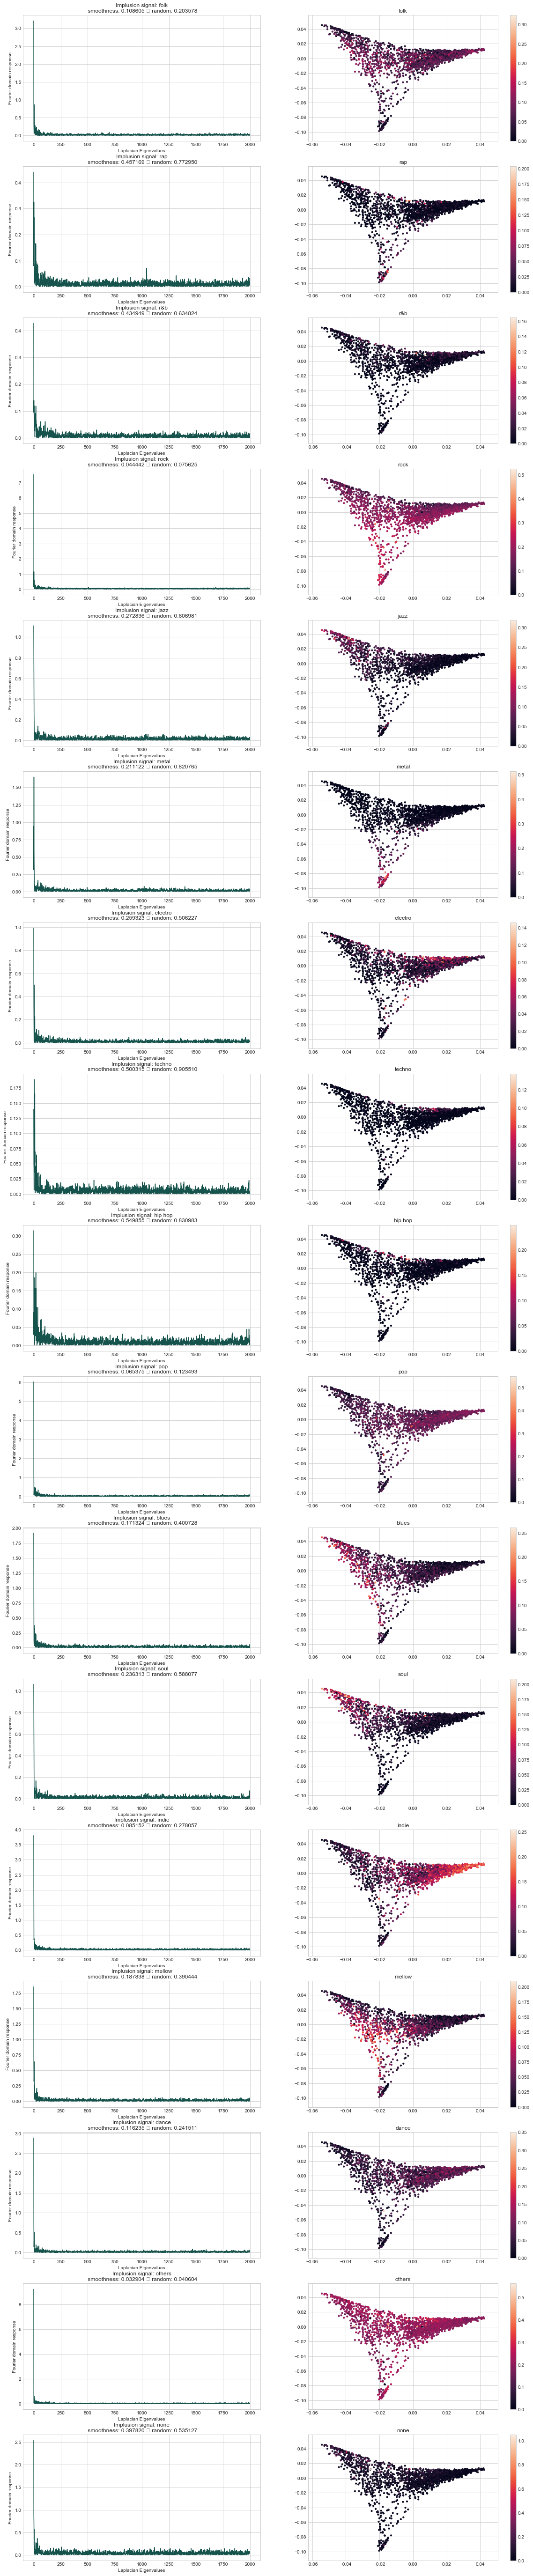

In [34]:
#create graph
G_likes = graphs.Graph(weights)
#compute fourier
G_likes.compute_laplacian('normalized')
G_likes.compute_fourier_basis()
#plot the signal
fig, axes = plt.subplots(len(genres.columns), 2, figsize=(20, 100))
i = 0

signals = genres.loc[list(likes_grouped.index.values)]
for column in likes_grouped.columns:
    signal = signals[column].values

    G_likes.set_coordinates(G_likes.U[:, [1, 2]])
    G_likes.plot_signal(signal,vertex_size=10, ax=axes[i, 1])

    axes[i, 0].plot(np.abs(G_likes.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    axes[i, 0].set_title('Implusion signal: %s' % column)
    axes[i, 1].set_title(column)
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_likes.L @ signal / np.linalg.norm(signal)**2

    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    for j in range(5):
        shuffled_signal = signals.sample(frac=1)[column].values
        smoothness_rand += shuffled_signal.T @ G_likes.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)
    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (column, smoothness,smoothness_rand))

    i += 1

This time the signals are the genre proportion of the music jammed by persons. These signals are very smooth, although they are less smooth than the likes genre proportion we can still conclude that the network well represents the music taste of the users. From that we are able to conclude that the likes people give to jams well define the taste of the people, also when it comes to the songs they share themselves. It means that we could use this network to predict the genre of song a person would jam, it also means that a recommender system for jam could be built based on both the jams and the likes. It could be very useful to advice people who only like others jams to share some song related to the jams they like.

# Appendix - Jam Spread Over Time Disproof

In this part we present the result we obtained when we analyzed the spread over time of the jams. The results are not very interesting because due to the large size of the network and the small size of people having shared a specific song. However since we take some time to carefully inspect that to be sure to not missout on something we would like to present here the result we found.

### The pruned network

We will now look at a pruned network where only nodes related to a given signal is kept. Later we will analyze the most relevant signals. We consider their relevance based on the amount of times the specific song has been jammed.

First we create a list containing the all the jammed songs sorted after the amount of times the song was jammed.

In [35]:
most_jammed = data[['jam_id','artist','title']].groupby(['artist','title']).count().sort_values(by='jam_id',ascending=False)

We then write a function to create any network with relevant weights.

### Example: The most jammed song

In [36]:
#G_grimes = Create_network('Grimes','Oblivion', data, net, merge)
#nx.write_gpickle(G_grimes,'G_grimes')
G_grimes = nx.read_gpickle('G_grimes')
print('The weigted network G_grimes has {} nodes.'.format(len(G_grimes.nodes())))
print('The weigted network G_grimes has {} edges.'.format(G_grimes.size()))
print('The nodes in G_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_grimes,weight='weight')).values()))/len(G_grimes.nodes())))

The weigted network G_grimes has 12488 nodes.
The weigted network G_grimes has 38940 edges.
The nodes in G_grimes has an average degree of 10.86.


In [37]:
#removing nodes with degree below 4
G_grimes_nodes = list(G_grimes.nodes())
G_grimes_degrees = G_grimes.degree(G_grimes_nodes,weight='weight')

for i in G_grimes_nodes:
    if G_grimes.degree[i] < 4:
        G_grimes.remove_node(i)
if not(nx.is_connected(G_grimes)):
    #keeping the largest connected component
    G_grimescc_w = sorted(nx.connected_component_subgraphs(G_w), key = len, reverse=True)
    G_grimescc_w = Gcc_w[0]
else:
    G_grimescc_w = G_grimes

print('The weigted network Gcc_grimes has {} nodes.'.format(len(G_grimescc_w.nodes())))
print('The weigted network Gcc_grimes has {} edges.'.format(G_grimescc_w.size()))
print('The nodes in Gcc_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_grimescc_w,weight='weight')).values()))/len(G_grimescc_w.nodes())))

The weigted network Gcc_grimes has 2584 nodes.
The weigted network Gcc_grimes has 25931 edges.
The nodes in Gcc_grimes has an average degree of 37.12.


Now we define the signal.

In [38]:
#create signal for Grimes Oblivion
data_grimes = create_signal(G_grimes,'Grimes','Oblivion', data)

/Users/antoinewehenkel/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 86/86 [00:45<00:00,  1.90it/s]


In order to analyze the created signal we compute the Laplacian and fourier basis:

In [39]:
#create graph
G_grimes_adj = nx.adjacency_matrix(G_grimes)
G_grimes_f = graphs.Graph(G_grimes_adj)

#compute fourier
G_grimes_f.compute_laplacian('normalized')
G_grimes_f.compute_fourier_basis()

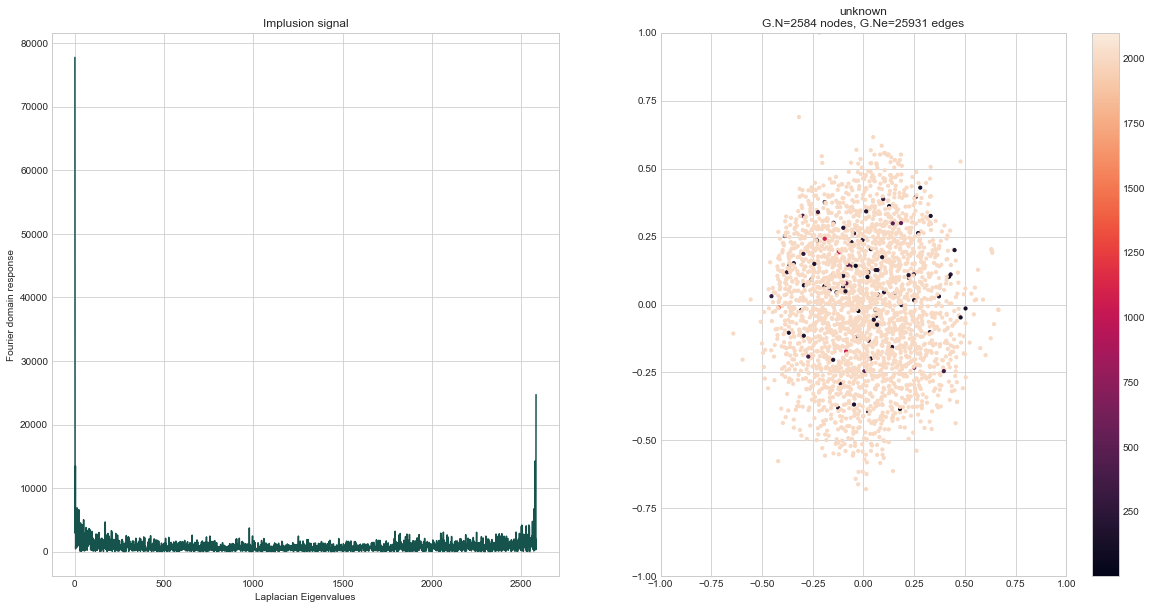

In [40]:
#plot the signal
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

signal = data_grimes['signal'].values

G_grimes_f.set_coordinates()
G_grimes_f.plot_signal(signal,vertex_size=10, ax=axes[1])
plt.axis([-1,1,-1,1])

axes[0].plot(np.abs(G_grimes_f.gft(signal)))
axes[0].set_xlabel('Laplacian Eigenvalues')
axes[0].set_ylabel('Fourier domain response')
axes[0].set_title('Implusion signal')

Since most of the people have not shared the song it is difficult to evaluate the smoothness of the signal. So in order to try to answer the question: "Does jams spread over time?". We build specific network where every person in it has shared the same song, this network is still based on the social links between people. Then we evaluate if the signal of time is smooth or not. If yes we can conclude that the music really propagates through the network.

('Grimes', 'Oblivion')

The weigted network Gcc has 458 nodes.
The weigted network Gcc has 1072 edges.
The nodes in Gcc has an average degree of 38.51.
Signal gradient: 0.638350
Shuffled signal gradient: 0.692312
('Arctic Monkeys', 'Do I Wanna Know?')

The weigted network Gcc has 522 nodes.
The weigted network Gcc has 1636 edges.
The nodes in Gcc has an average degree of 85.31.
Signal gradient: 0.760722
Shuffled signal gradient: 0.807069
('Lorde', 'Royals')

The weigted network Gcc has 283 nodes.
The weigted network Gcc has 463 edges.
The nodes in Gcc has an average degree of 23.54.
Signal gradient: 0.531648
Shuffled signal gradient: 0.520541
('Alt-J', 'Breezeblocks')

The weigted network Gcc has 375 nodes.
The weigted network Gcc has 854 edges.
The nodes in Gcc has an average degree of 29.94.
Signal gradient: 0.588287
Shuffled signal gradient: 0.640411
('The Lumineers', 'Ho Hey')

The weigted network Gcc has 233 nodes.
The weigted network Gcc has 354 edges.
The nodes in Gcc has an ave

2018-01-22 20:53:25,705:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


The weigted network Gcc has 583 edges.
The nodes in Gcc has an average degree of 55.10.
Signal gradient: 0.604825
Shuffled signal gradient: 0.712556
('M83', 'Midnight City')

The weigted network Gcc has 180 nodes.
The weigted network Gcc has 252 edges.
The nodes in Gcc has an average degree of 22.94.
Signal gradient: 0.594562
Shuffled signal gradient: 0.678420
('CHVRCHES', 'The Mother We Share')

The weigted network Gcc has 275 nodes.
The weigted network Gcc has 365 edges.
The nodes in Gcc has an average degree of 20.47.
Signal gradient: 0.508720
Shuffled signal gradient: 0.579845
('James Blake', 'Retrograde')

The weigted network Gcc has 338 nodes.
The weigted network Gcc has 655 edges.
The nodes in Gcc has an average degree of 53.89.
Signal gradient: 0.822835
Shuffled signal gradient: 0.844218


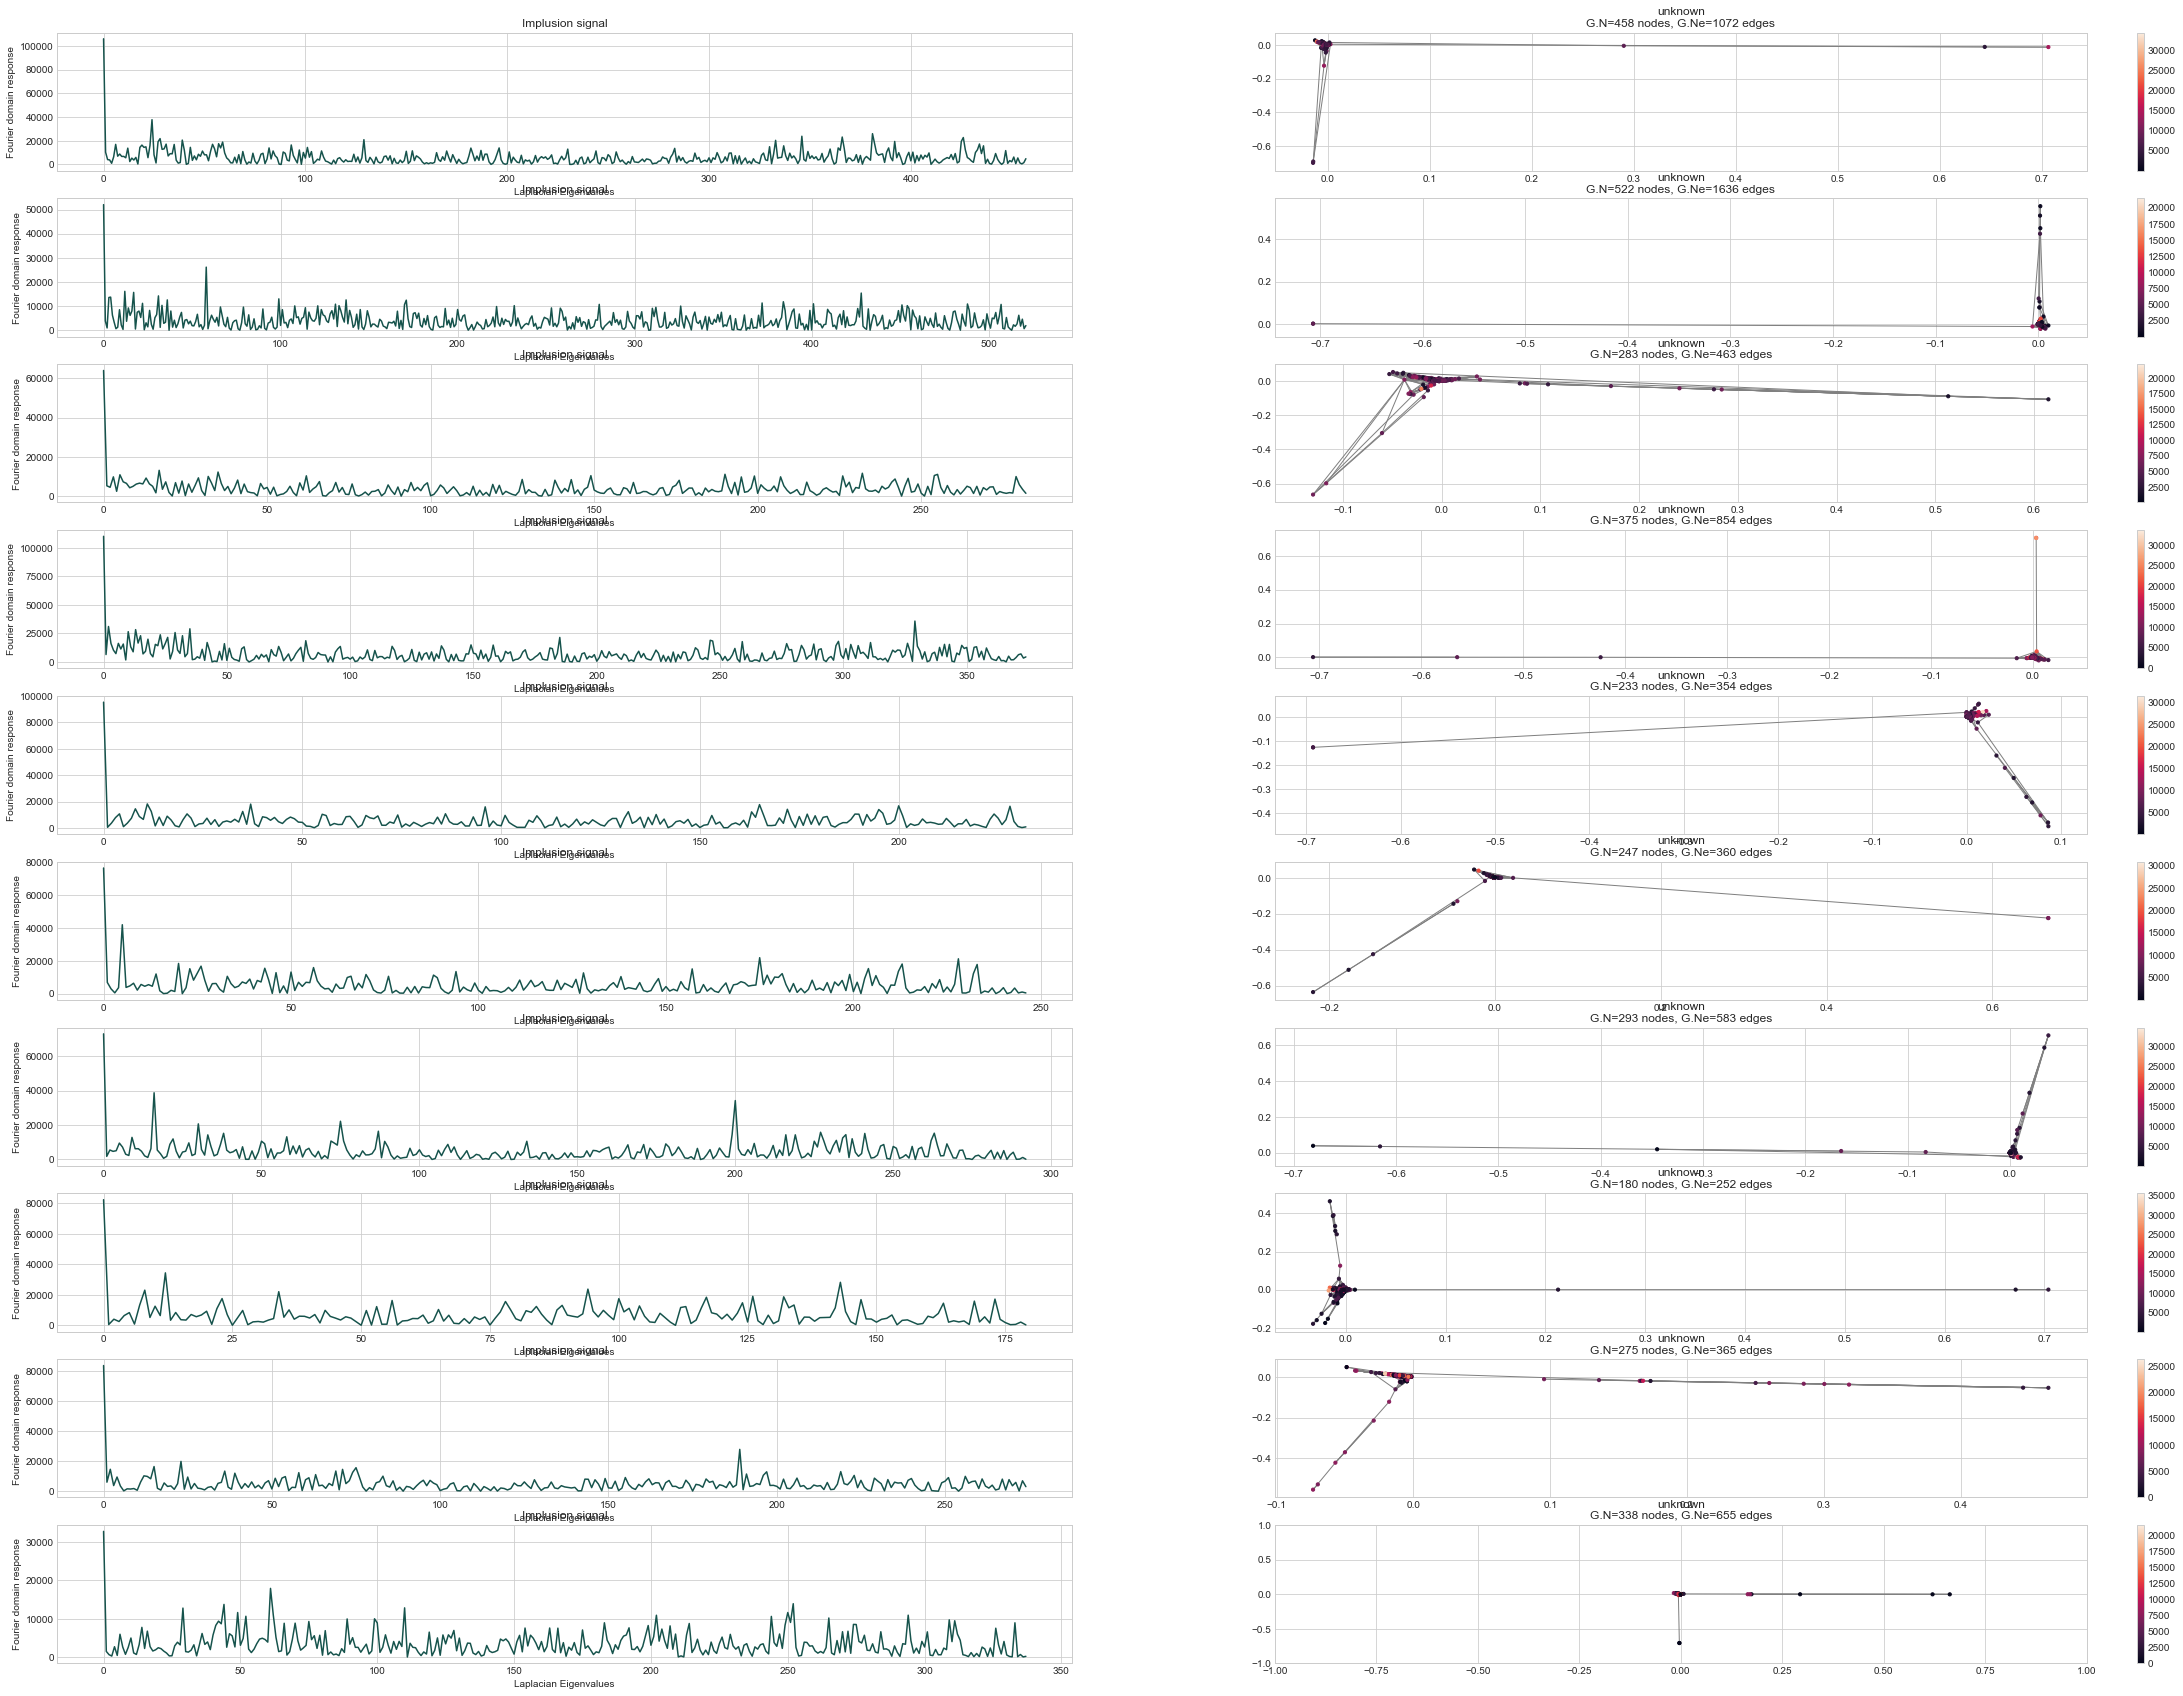

In [41]:
fig, axes = plt.subplots(10, 2, figsize=(40, 30))
i = 0
for id, row in most_jammed.iloc[:10].iterrows():
    print(row.name[0:2])
    G_grimes_small = Create_network_jam(row.name[0], row.name[1], net, grouped, data, merge)
    getInsightSongJam(row.name[0], row.name[1], fig, axes[i, :], G_grimes_small, data)
    i+=1

Here we see the networks and fourier decomposition of the ten most jammed songs and it is clear that none of them are very smooth. To know whether there exists any information about the propagation in the network we compare the smoothnnes (computed as the norm of the gradient) with the smoothness of an identical network where the signal is placed randomly. We observe that for almost all the networks the smoothness does improve. Hoewever not sufficiently for the network to really explain the propagation.

## Conclusion

During this project we discovered many things about ThisIsMyJam social network. By following the data analysis pipeline presented in the course, we started first by collecting the data and ensuring that this was ready for the next stages of analysis. In this sake, the Spotify API was used to enrich the data with additional information.

In order to get an overview of the content of the data and the possible correlations between the attributes, an exploratory analysis was done to get insights on the genre prefrences of the user jams. Furthermore, in this part we were able to analyze two different networks, both built based on the social relationships between people. These networks ended to not well represent the music tastes of people, and from that we concluded that inference of people taste would be difficult in these networks. 

In the data analysis, we first confirmed the results found in the exploratory analysis about the inadaptability of the social network to represent the music taste of the present communities. We then built an artificial network which represented better the music preference links between people. It has been done using the genre of music liked by users. This network has shown how it is very relevant to predict the genre of the jammed music by using spectral graph theory. We learned that the genres of the jammed music spread smoothly on this network. 

Finally, our attempts to analyze the propagation of the jam timestamps in the social networks were not fruitful.